<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/regression/linear_regression_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측


## LinearRegression 클래스 - Ordinary Least Squares

<h4> : 예측값과 실제값의 RSS를 최소화해 OLS추정 방식으로 구현한 클래스</h4>
- fit() 메서드로 X, y 배열을 입력 받으면 회귀 계수(Coefficients)인 W를 coef_ 속성에 저장

<h3>파라미터</h3>

- fit_intercept
  - boolean 값으로 default = True
  - intercept(절편)값을 계산할 것인지 말지를 지정
  - False라면 intercept가 사용되지 않고 0으로 지정됨
- normalize
   - boolean 값으로 default = False
   - fit_intercept가 False인 경우 이 파라미터는 무시됨
   - True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화함

<h3>속성</h3>

- coef_ : fit() 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성
  - Shape는 (Target 값 개수, 피처 개수)
- intercept_ : intercept 값

Ordinary Least Squares 기반의 회귀 계수 계산은 다중공선성의 영향을 많이 받음  
일반적으로 상관관계가 높은 피처는 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용함  
또한 많은 피처가 다중공선성 문제를 가지고 있다면 PCA를 통해 차원 축소를 수행하는것도 고려할 수 있음

## 회귀 평가 지표

$MAE$
- Mean Absolute Error(MAE)이며 실제값과 예측값의 차이를 절대값으로 변환해 평균한 것
- $MAE\;=\;\frac{1}{n}\sum_{i=1}^{n}|Yi-\hat Yi|$
- metrics.mean_absolute_error
- 'neg_mean_absolute_error

$MSE$
- Mean Squared Error(MSE)이며 실제값과 예측값의 차이를 제곱해 평균한 것
- $MSE\;=\;\frac{1}{n}\sum_{i=1}^{n}(Yi-\hat Yi)^2$
- metrics.mean_squared_error
- 'neg_mean_squared_error

$RMSE$
- MSE값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있음, MSE에 루트를 씌운 것
- $RMSE\;=\;\sqrt{\frac{1}{n}\sum_{i=1}^{n}(Yi-\hat Yi)^2}$
- metrics에서 제공하지 않기 때문에 mse에 루트를 적용해야함

$R^2$
- 분산 기반으로 예측 성능을 평가함
- 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며. 1에 가까울수록 예측 정확도가 높음
- $R^2\;=\;\frac{예측값\,Variance}{실제값\,Variance}$
- metrics.r2_score
- 'r2'

cross_val_score, GridSearchCV같은 Scoring 함수에는 평가 지표를 할때 유의해야할 사항이 있음  
'neg'라는 접두어가 붙어 있음 이는 Negative(음수)값을 가진다는 의미임  
실제로 MAE는 절대값의 합이기에 음수를 가질 수 없지만 의도적으로 음수를 주는것임  
**이유는 Scoring 함수는 score값이 클수록 좋은 평가 결과를 자동평가하기 때문에**  
**실제값과 예측값의 차이가 커지면 좋은모델이 아닌 나쁜모델이기 때문에 음수를 적용하는 것임**  

# 코드구현

피처에 대한 설명

- CRIM : 지역별 범죄 발생률
- ZN : 25,000평방피트를 초과하는 거주 지역의 비율
- INDUS : 비상업 지역 넓이 비율
- CHAS : 찰스강에 대한 더미 변수(강의 경계에 위한 경우 1, 아니면 0)
- NOX : 일산화질소 농도
- RM : 거주할 수 있는 방 개수
- AGE : 1940년 이전에 건축된 소유 주택의 비율
- DIS : 5개 주요 고용센터까지의 가중거리
- RAD : 고속도로 접근 용이도
- TAX : 10,000달러당 재산세율
- PTRATIO : 지역의 교사와 학생 수 비율
- B : 지역의 흑인 거주 비율
- LSTAT : 하위 계층의 비율
- MEDV : 본인 소유의 주택 가격(중앙값)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings("ignore")
#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임
# 이를 PRICE 칼럼으로 DataFrame에 추가
bostonDF["PRICE"] = boston.target
print("Boston 데이터 세트 크기 : ", bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 :  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


데이터 세트는 NULL 값이 없으며 모두 float64 타입이다.

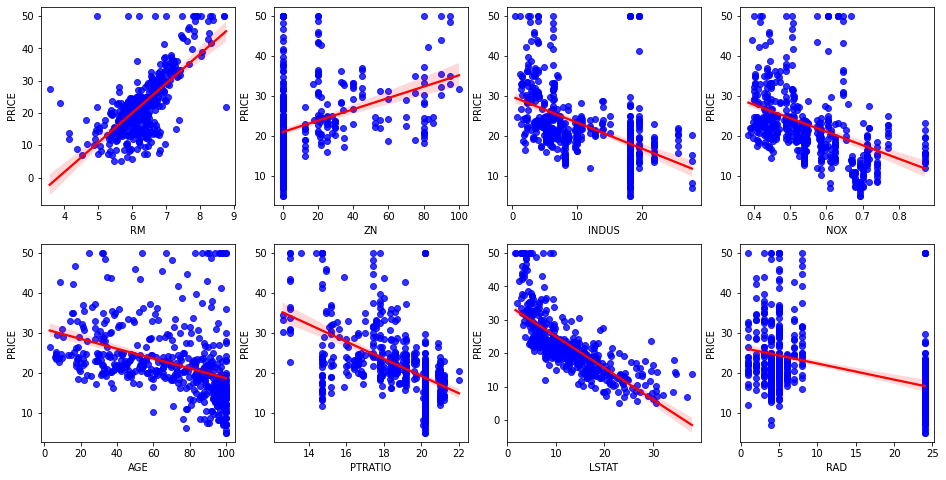

In [11]:
f, ax = plt.subplots(2,4, figsize=(16,8))
lm_features = ["RM", "ZN","INDUS","NOX","AGE","PTRATIO","LSTAT","RAD"]
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  #시본의 regplot을 이요해 산점도와 선형 회귀 직선을 함께 표현
  sns.regplot(x=feature, y="PRICE", data=bostonDF, ax=ax[row][col],scatter_kws={'color':'blue'},line_kws={"color":"red"})

RM과 LSTAT의 PRICE에 대한 영향이 많이 나타남  
RM(방개수)은 방의 크기가 클수록 가격이 증가하는 모습을 보여주고,  
LSTAT(하위계층비율)이 높을수록 가격이 떨어지는 모습을 보여줌  

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 

X = bostonDF.drop("PRICE", axis=1)
y = bostonDF["PRICE"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE : {:.3f}, RMSE : {:.3f}".format(mse, rmse))
print("Variance score : {:.3f}".format(r2_score(y_test, y_pred)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [18]:
print("절편값 : {}".format(lr.intercept_))
print("최귀 계수값 : {}".format(np.round(lr.coef_,1)))

절편값 : 40.995595172164755
최귀 계수값 : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [20]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성
coeff = pd.Series(data=np.round(lr.coef_,1), index = X_train.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

RM이 양의 값으로 회귀 계수가 가장 크며, NOX 피처의 회귀 계수 음의 값이 커보임

In [25]:
from sklearn.model_selection import cross_val_score

y = bostonDF["PRICE"]
X = bostonDF.drop("PRICE", axis=1)

lr = LinearRegression()

#cross_val_score로 5폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE를 구함
neg_mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv= 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)


print("5 fold 의 개별 Negative MSE scores : {}".format(np.round(neg_mse_scores,2)))
print("5 fold 의 개별 RMSE scores : {}".format(np.round(rmse_scores,2)))
print("5 fold 의 개별 평균 RMSE scores : {:.3f}".format(avg_rmse))

5 fold 의 개별 Negative MSE scores : [-12.46 -26.05 -33.07 -80.76 -33.31]
5 fold 의 개별 RMSE scores : [3.53 5.1  5.75 8.99 5.77]
5 fold 의 개별 평균 RMSE scores : 5.829
